# Single Shot Object Detection

SSD (Single Shot Multi-box Detection) is detecting objects in images using a single deep neural network. This tutorial use a model provided from [TensorFlow](https://github.com/tensorflow/examples/blob/master/lite/examples/object_detection/android/README.md).

In [1]:
import (
    "log"
    "github.com/mattn/go-tflite"
)

Load model.

In [2]:
model := tflite.NewModelFromFile("detect.tflite")
if model == nil {
    log.Fatal("cannot load model")
}

Create interpreter and allocate tensors.

In [3]:
interpreter := tflite.NewInterpreter(model, nil)
interpreter.AllocateTensors()
input := interpreter.GetInputTensor(0)
wanted_height := input.Dim(1)
wanted_width := input.Dim(2)
wanted_channels := input.Dim(3)

Make sure dimensions.

In [4]:
import "fmt"
fmt.Println(wanted_width, wanted_height, wanted_channels)

300 300 3


10 <nil>

Then, make input tensor.

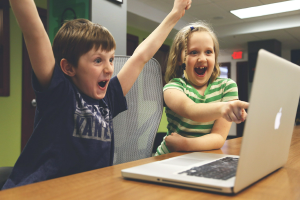

In [5]:
import (
    "os"
    "image"
    _ "image/jpeg"
    "github.com/nfnt/resize"
)

f, err := os.Open("example.jpg")
if err != nil {
    log.Fatal(err)
}

img, _, err := image.Decode(f)
if err != nil {
    log.Fatal(err)
}

resize.Resize(300, 0, img, resize.NearestNeighbor)

In [6]:
qp := input.QuantizationParams()
log.Printf("width: %v, height: %v, type: %v, scale: %v, zeropoint: %v", wanted_width, wanted_height, input.Type(), qp.Scale, qp.ZeroPoint)
log.Printf("input tensor count: %v, output tensor count: %v", interpreter.GetInputTensorCount(), interpreter.GetOutputTensorCount())
if qp.Scale == 0 {
    qp.Scale = 1
}
bb := make([]byte, wanted_width*wanted_height*wanted_channels)

resized := resize.Resize(uint(wanted_width), uint(wanted_height), img, resize.NearestNeighbor)
for y := 0; y < wanted_height; y++ {
    for x := 0; x < wanted_width; x++ {
        r, g, b, _ := resized.At(x, y).RGBA()
        bb[(y*wanted_width+x)*3+0] = byte(float64(int(b)-qp.ZeroPoint) * qp.Scale)
        bb[(y*wanted_width+x)*3+1] = byte(float64(int(g)-qp.ZeroPoint) * qp.Scale)
        bb[(y*wanted_width+x)*3+2] = byte(float64(int(r)-qp.ZeroPoint) * qp.Scale)
    }
}
copy(input.UInt8s(), bb)

270000

In [7]:
interpreter.Invoke()

OK

Output tensor is 4 elements.

|Index|Name     |Description                                                                                                                                                     |
|----|---------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------|
|0    |Locations|Multidimensional array of `[10][4]` floating point values between 0 and 1_ the inner arrays representing bounding boxes in the form `[top_ left_ bottom_ right]`|
|1    |Classes  |Array of 10 integers (output as floating point values) each indicating the index of a class label from the labels file                                          |
|2    |Scores   |Array of 10 floating point values between 0 and 1 representing probability that a class was detected                                                            |
|3    |Number   |Number and detections	Array of length 1 containing a floating p                                                                                               |


In [8]:
output := interpreter.GetOutputTensor(0)

var loc [10][4]float32
var clazz [10]float32
var score [10]float32
var nums [1]float32
output.CopyToBuffer(&loc[0])
interpreter.GetOutputTensor(1).CopyToBuffer(&clazz[0])
interpreter.GetOutputTensor(2).CopyToBuffer(&score[0])
interpreter.GetOutputTensor(3).CopyToBuffer(&nums[0])
num := int(nums[0])

correct results and sort by score.

In [9]:
import "sort"
type ssdClass struct {
    loc   [4]float32
    score float64
    index int
}
classes := make([]ssdClass, 0, len(clazz))
var i int
for i = 0; i < num; i++ {
    idx := int(clazz[i] + 1)
    score := float64(score[i])
    classes = append(classes, ssdClass{loc: loc[i], score: score, index: idx})
}
sort.Slice(classes, func(i, j int) bool {
    return classes[i].score > classes[j].score
})
classes = classes[:num]

Draw boxes arround detected objects.

In [11]:
import (
    "bufio"
    "fmt"
    "image/color"
    "golang.org/x/image/colornames"
    "github.com/llgcode/draw2d"
    "github.com/llgcode/draw2d/draw2dimg"
)

In [12]:
func loadLabels(filename string) ([]string, error) {
    labels := []string{}
    f, err := os.Open(filename)
    if err != nil {
        return nil, err
    }
    defer f.Close()
    scanner := bufio.NewScanner(f)
    for scanner.Scan() {
        labels = append(labels, scanner.Text())
    }
    return labels, nil
}
labels, err := loadLabels("labelmap.txt")
if err != nil {
    log.Fatal(err)
}

In [13]:
canvas := image.NewRGBA(img.Bounds())
gc := draw2dimg.NewGraphicContext(canvas)
draw2d.SetFontFolder("/etc/alternatives")
draw2d.SetFontNamer(func(fontData draw2d.FontData) string {
    return "fonts-japanese-gothic.ttf"
})
gc.DrawImage(img)
gc.SetFontSize(25)
size := img.Bounds()
for i, class := range classes {
    label := "unknown"
    if class.index < len(labels) {
        label = labels[class.index]
    }
    gc.BeginPath()
    c := colornames.Map[colornames.Names[class.index]]
    gc.SetStrokeColor(c)
    gc.SetLineWidth(1)
    gc.MoveTo(float64(size.Dx())*float64(class.loc[1]), float64(size.Dy())*float64(class.loc[0]))
    gc.LineTo(float64(size.Dx())*float64(class.loc[3]), float64(size.Dy())*float64(class.loc[0]))
    gc.LineTo(float64(size.Dx())*float64(class.loc[3]), float64(size.Dy())*float64(class.loc[2]))
    gc.LineTo(float64(size.Dx())*float64(class.loc[1]), float64(size.Dy())*float64(class.loc[2]))
    gc.Close()
    gc.Stroke()
    s := fmt.Sprintf("%d %.5f %s", i, class.score, label)
    gc.StrokeStringAt(s, float64(size.Dx())*float64(class.loc[1]), float64(size.Dy())*float64(class.loc[0]))
}

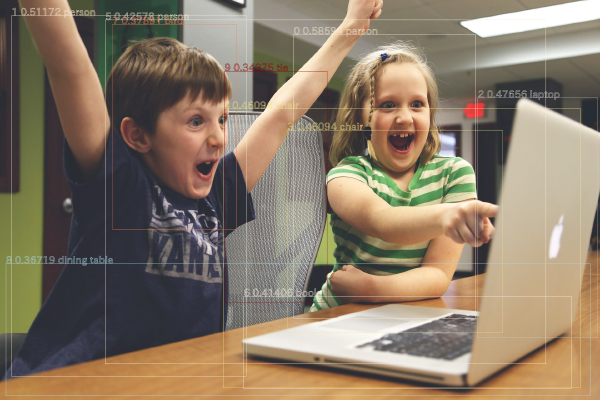

In [14]:
resize.Resize(600, 0, canvas, resize.NearestNeighbor)